In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [37]:
# prepare data
def parse_data() -> list:
    file_name = '../data/names_new.csv'
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
    return [d.split(',')[0] for d in data]

def setup_data(data) -> tuple:
    clean_data = []
    valid_chars = 'âabcçdefgğhıiîjklmnoöprsştuüûvyz'
    for name in data:
        name = name.replace('İ', 'i') # Capital İ is two chars in ascii
        if all([c in valid_chars for c in name.lower()]):
            clean_data.append(name.lower())
    new_data = clean_data

    itos = {i+1:c for i, c in enumerate(valid_chars)}
    itos[0] = '.' # start and end token
    stoi = {c:i for i, c in itos.items()}

    return new_data, itos, stoi

data, itos, stoi = setup_data(parse_data())
vocab_size = len(itos)

In [38]:
# Hyperparameters
block_size = 5
num_dimensions = 10
num_hidden_neurons = 100
num_epochs = 100000
minibatch_size = 64

In [51]:
def build_dataset(words, block_size=3):
    xs, ys = [], [] 
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            idx = stoi[ch]
            xs.append(context)
            ys.append(idx)
            # print(''.join(itos[i] for i in context), '-->', itos[idx])
            context = context[1:] + [idx]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

random.shuffle(data)
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
x_train, y_train = build_dataset(data[:n1],block_size)
x_val, y_val = build_dataset(data[n1:n2],block_size)
x_test, y_test = build_dataset(data[n2:],block_size)

In [66]:
# Layers that we implemented in the previous notebook
# This time they are pytorchified
class Linear:

    def __init__(self, fan_in, fan_out, bias=True) -> None:
        # setup the w
        self.w = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5) # dividing or multiplying?
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # forward pass
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.w, self.b] if self.b is not None else [self.w, []]


class BatchNorm:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones((1, dim)) # can i use dim instead of (1, dim) ?
        self.beta = torch.zeros((1, dim))

        self.running_mean = torch.zeros((1, dim))
        self.running_var = torch.ones((1, dim))

        self.momentum = momentum
        self.eps = eps
        self.training = True
        
    def __call__(self, x):
        if self.training:
            cur_mean = x.mean(0, keepdim=True)
            cur_var = x.var(0, keepdim=True, unbiased=True) # whhat is unbiased for
        else:
            cur_mean = self.running_mean
            cur_var = self.running_var
        self.out = ((x - cur_mean) / torch.sqrt(cur_var + self.eps)) * self.gamma + self.beta

        # Updating running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * cur_mean
                self.running_std = (1-self.momentum) * self.running_std + self.momentum * cur_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [113]:
C = torch.randn((vocab_size, num_dimensions))
# Setup the model as a list of layers
model = [
    Linear(num_dimensions * block_size, num_hidden_neurons), 
    Tanh(),
    Linear(num_hidden_neurons, num_hidden_neurons),
    Tanh(),
    Linear(num_hidden_neurons, num_hidden_neurons),
    Tanh(),
    Linear(num_hidden_neurons, num_hidden_neurons),
    Tanh(),
    Linear(num_hidden_neurons, num_hidden_neurons),
    Tanh(),
    Linear(num_hidden_neurons, vocab_size),
]

# Apply gain and confidence reduction
with torch.no_grad():
    model[-1].w *= 0.1
    # gain on all the other layers
    for layer in model[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 3 # tanh gain is 5/3

# Collect all the parameters
params = [C] + [p for layer in model for p in layer.parameters()]
for p in params:
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.numel() for p in params)}")

Total number of parameters: 49163


In [123]:
# Setup the training loop
loss_i = []
ud = []

for epoch in range(num_epochs):
    # minibatch
    idx = torch.randint(0, x_train.shape[0], (minibatch_size,))
    x = x_train[idx]
    y = y_train[idx]
    
    # forward pass
    x = C[x] # embedding the chars into vectors
    x = x.view(x.shape[0], -1) # concat the vectors
    for layer in model:
        x = layer(x)
    loss = F.cross_entropy(x, y) # loss function

    # backward pass
    for layer in model:
        layer.out.retain_grad() # for debugging
    for p in params:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = 0.1 if epoch < num_epochs / 2 else 0.01
    for p in params:
        p.data -= lr * p.grad

    # print the loss and log
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: {loss.item()}", end='\r')
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in params])

    if epoch == 1000:
        break # for debugging

# Diagnostics

Layer 0 (      Tanh): mean -0.01, std +0.86, saturation 48.11%
Layer 1 (      Tanh): mean -0.04, std +0.85, saturation 42.94%
Layer 2 (      Tanh): mean -0.08, std +0.85, saturation 45.06%
Layer 3 (      Tanh): mean +0.03, std +0.85, saturation 44.88%
Layer 4 (      Tanh): mean -0.02, std +0.86, saturation 47.12%


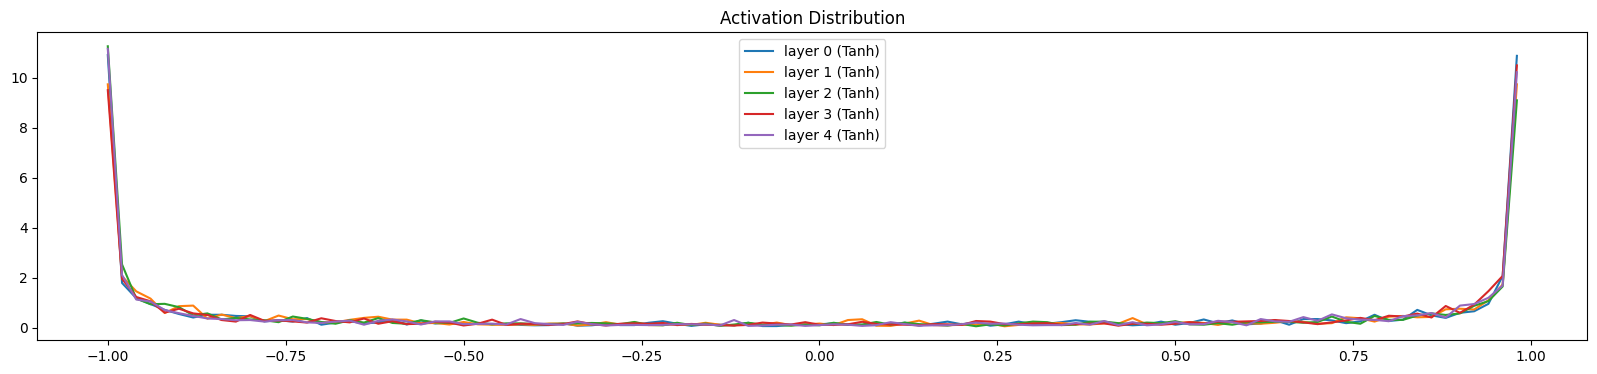

In [124]:
# Visualize Histograms of the activations (forward pass)
plt.figure(figsize=(20, 4))
legends = []
for layer in model[:-1]:
    if isinstance(layer, Tanh):
        t = layer.out
        print("Layer %d (%10s): mean %+.2f, std %+.2f, saturation %.2f%%" % (
            len(legends), "Tanh", t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {len(legends)} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("Activation Distribution");

Text(0, 0.5, 'Log10 Loss')

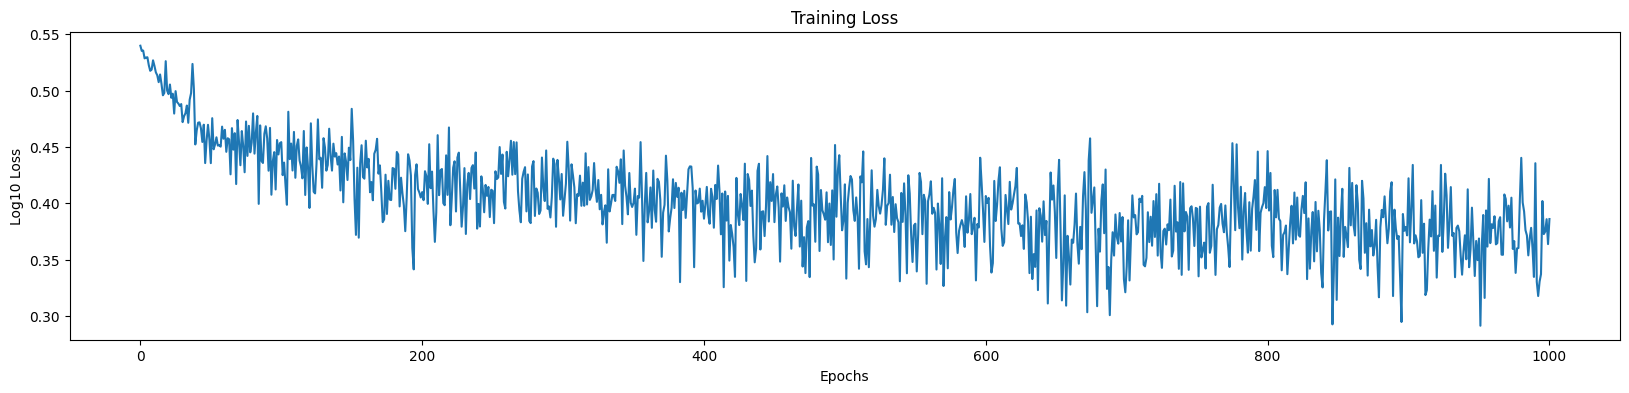

In [125]:
# Plot training loss
plt.figure(figsize=(20, 4))
plt.plot(loss_i)
plt.title("Training Loss");
plt.xlabel("Epochs")
plt.ylabel("Log10 Loss")

Layer 0 (      Tanh): mean -0.000014, std 3.578211e-03
Layer 1 (      Tanh): mean +0.000014, std 2.801716e-03
Layer 2 (      Tanh): mean +0.000027, std 2.114713e-03
Layer 3 (      Tanh): mean +0.000033, std 1.569805e-03
Layer 4 (      Tanh): mean +0.000024, std 1.140419e-03


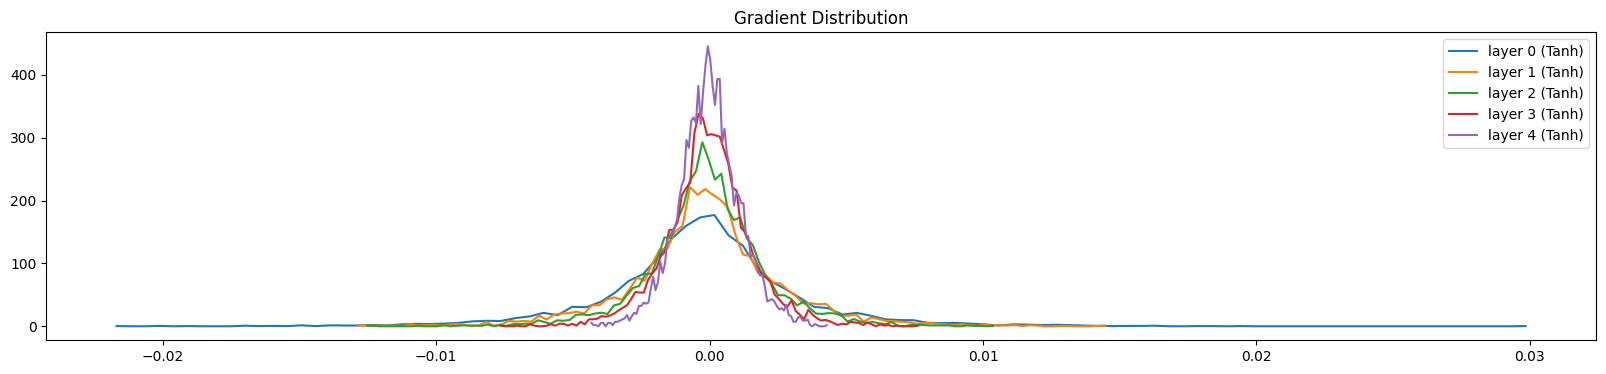

In [126]:
# Gradient Histograms
plt.figure(figsize=(20, 4))
legends = []
for layer in model[:-1]:
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("Layer %d (%10s): mean %+f, std %e" % (
            len(legends), "Tanh", t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {len(legends)} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("Gradient Distribution");

weights torch.Size([33, 10]) - mean -0.000363 - std 1.828274e-02 - grad:data ratio 1.744462e-02
weights torch.Size([50, 100]) - mean +0.000100 - std 1.229075e-02 - grad:data ratio 2.871845e-02
weights torch.Size([100, 100]) - mean -0.000097 - std 8.648635e-03 - grad:data ratio 2.910933e-02
weights torch.Size([100, 100]) - mean -0.000097 - std 6.621461e-03 - grad:data ratio 2.196204e-02
weights torch.Size([100, 100]) - mean -0.000069 - std 4.699664e-03 - grad:data ratio 1.578743e-02
weights torch.Size([100, 100]) - mean +0.000072 - std 3.463886e-03 - grad:data ratio 1.151333e-02
weights torch.Size([100, 33]) - mean +0.000000 - std 1.786738e-02 - grad:data ratio 2.394312e-01


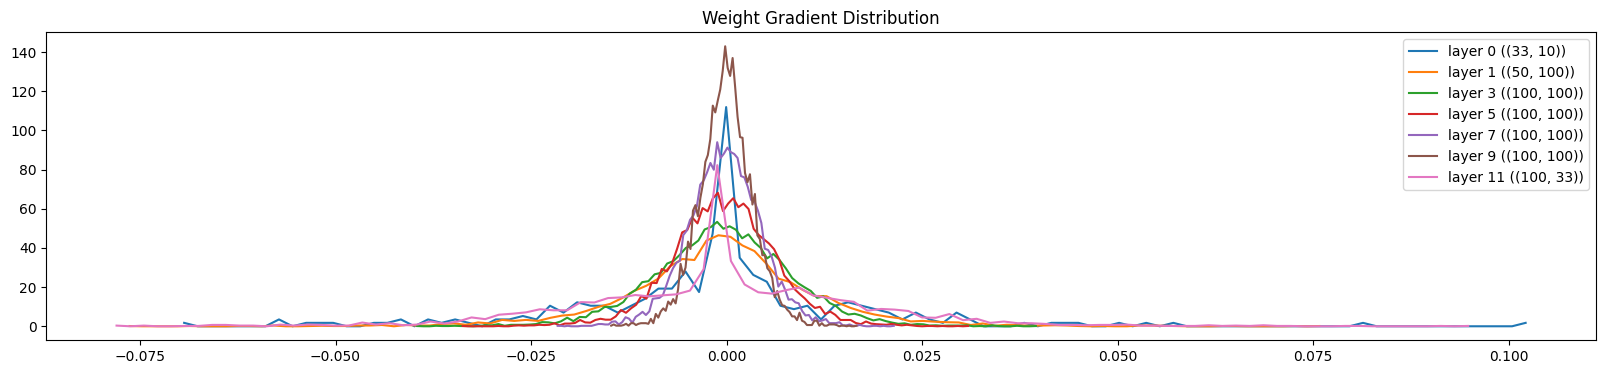

In [127]:
# Meethod 3
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        print("weights %10s - mean %+f - std %e - grad:data ratio %e" % (
            p.shape, t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({tuple(p.shape)})")
plt.legend(legends);
plt.title("Weight Gradient Distribution");

# What are we checking:
# 1. The std should be similar accross layers
# 2. The mean should be similar accross layers
# 3. The grad:data ratio should be similar accross layers
#
# Grad:data ratio gives us an intuition of what is the scale of the gradient compared to the actual values. This is important 
# because we will be taking a step update of the form w = w - lr * grad. If the gradient is too large compared to the actual
# values, we will be overshooting the minimum. If the gradient is too small compared to the actual values, we will be taking
# too many steps to reach the minimum.
#
# The std of the gradient is a measure of how much the gradient changes across the weights. If the std for a layer is too
# different from the std of the other layers, this will be an issue because this layer will be learning at a different rate
# than the other layers. 
#
# This is for initialization phase. If we let the network train for a while, it will fix this issue itself. Nevertheless,
# this is an issue especially if we are using a simple optimizer like SGD. If we are using an optimizer like Adam, this
# issue will be fixed automatically.

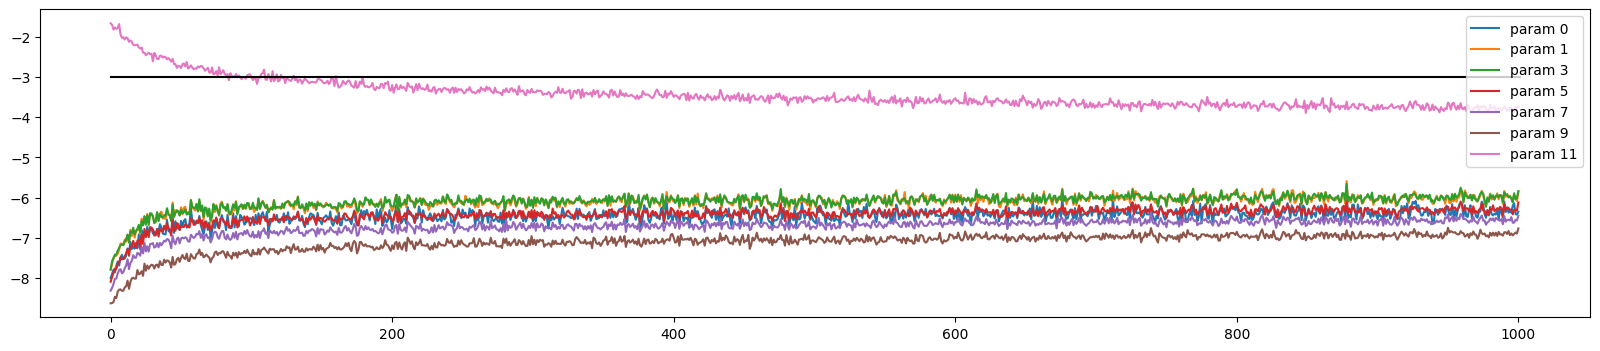

In [128]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(params):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);